## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
SEASON = '11'
N_MC = 20000

In [4]:
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [5]:
# df_exp.ksalign.hist(bins=100);

____
## Fit part

In [6]:
energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

525.0 550.0 562.5 575.0 587.5 600.0 612.5 625.0 637.5 650.0 662.5 675.0 687.5 700.0 712.5 725.0 737.5 750.0 762.5 775.0 787.5 800.0 812.5 825.0 837.5 850.0 862.5 875.0 887.5 900.0 912.5 925.0 935.0 945.0 950.0 962.5 975.0 987.5 1000.0 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [7]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (1000, (0, None)),    
    'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'k'    : ( 0.1, (0, 20)),
}

In [8]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 3*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [9]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 525.0 MeV


In [10]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20)
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'n_bkg', 'k', 'm'])
m_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad()
assert m_exp.valid

In [11]:
# for par in m_exp.parameters:
#     m_exp.fixed[par] = True if par not in ['n_sig'] else False

In [12]:
m_mc.migrad().minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.986e+04                 │             Nfcn = 1205              │
│ EDM = 1.09e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │  2.77e3   │  0.04e3   │  -0.04e3   │   0.04e3   │    0    │         │       │
│ 1 │ m     │   1.06    │   0.21    │   -0.21    │    0.21    │   -5    │    5    │       │
│ 2 │ sL    │   4.37    │   0.16    │   -0.16    │    0.16    │    1    │   10    │       │
│ 3 │ sR    │   2.85    │   0.21    │   -0.20    │    0.22    │    1    │   10    │       │
│ 4 │ aL    │  0.0775   │  0.0034   │  -0.0033   │   0.0033   │    0    │   10    │       │
│ 5 │ aR    │   0.229   │   0.008   │   -0.008   │   0.008    │    0    │   10    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         n_sig         │           m           │          sL           │          sR           │          aL           │          aR           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -40    │    40     │   -0.21   │   0.21    │   -0.16   │   0.16    │   -0.20   │   0.22    │  -0.0033  │  0.0033   │  -0.008   │   0.008   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR │
├───────┼─────────────────────────────────────────────────────────────┤
│ n_sig │  1.31e+03    0.0836    0.0379   -0.0907  -0.00128  -0.00124 │
│     m │    0.0836    0.0452    0.0273    -0.035 -0.000341   0.00079 │
│    sL │    0.0379    0.0273     0.027   -0.0166 -0.000401  0.000518 │
│    sR │   -0.0907    -0.035   -0.0166    0.0443  0.000223  -0.00112 │
│    aL │  -0.00128 -0.000341 -0.000401  0.000223  1.13e-05 -6.49e-06 │
│    aR │  -0.00124   0.00079  0.000518  -0.00112 -6.49e-06  6.84e-05 │
└───────┴─────────────────────────────────────────────────────────────┘

,n_sig_exp,n_bkg_exp,n_sig_mc
525.0,966.503366,90.49831,2770.999631


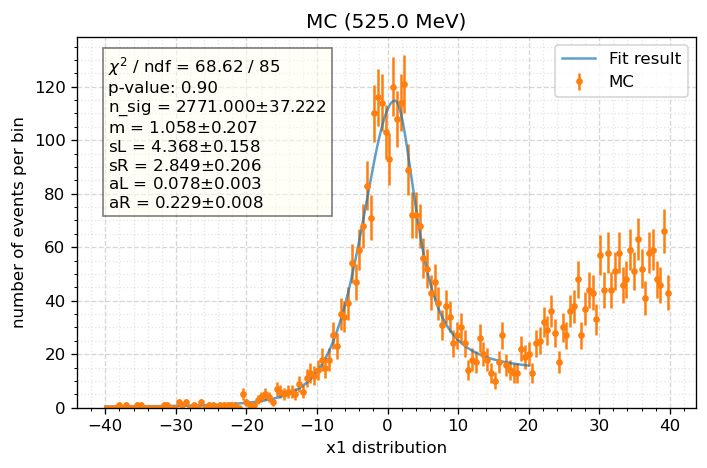

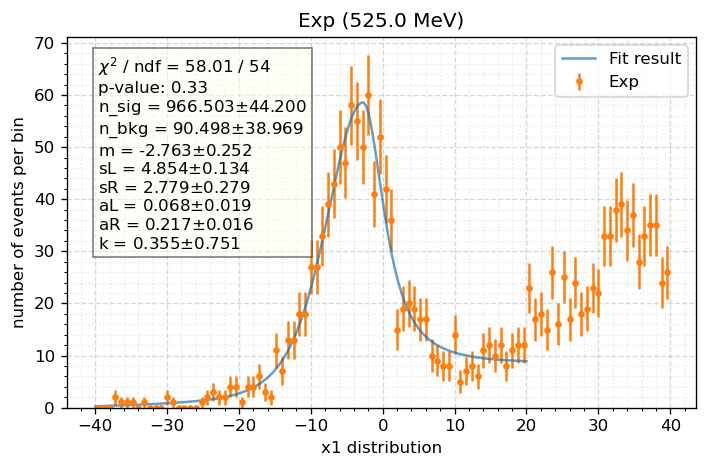

In [34]:
#Plot and save data

def plot_fit_data(save=True):
    pys.plot_fit(dataM, pyfit.sig_pdf, m_mc, 150, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
    if save:
        if not(os.path.isdir(f'images/fit{SEASON}')):
            os.mkdir(f'images/fit{SEASON}')
        plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, pyfit.pdf, m_exp, 100, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)

plot_fit_data(save=True)

if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
        add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

Распределения

In [71]:
res_df.to_csv(f'../data/{SEASON}/results/signal.csv')

In [161]:
res_df[['n_sig_exp', 'n_sig_exp_err']]

,n_sig_exp,n_sig_exp_err
641.0,352.328084,17.468406
650.0,106.733137,12.441450
675.0,92.109045,12.046118
700.0,54.870984,9.700130
725.0,83.944604,11.899339
750.0,117.429777,10.942273
775.0,143.334079,9.629576
800.0,280.846588,14.340400
825.0,291.060724,16.054307
840.0,83.121625,7.132346


Triggers

In [72]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
507.0,17537,507.533905,1,1.582354,1.328387,-1.749669,-2.407628,224.194611,202.120789,-0.244531,...,499.287354,99.066757,0.999991,0.309530,2.683964,224.222916,201.245834,1.747909,0.726466,0.004129
507.0,17537,507.533905,1,2.042630,1.182527,0.652956,0.307650,239.896194,181.274368,-0.521348,...,496.958313,95.964180,0.994825,0.880381,2.775894,239.902542,181.035553,2.595559,-3.059284,0.101781
507.0,17537,507.533905,1,1.644828,1.495863,13.689467,13.262314,233.933685,182.573288,1.190475,...,489.658813,51.892456,0.972175,7.364120,3.129058,228.194153,176.362656,31.376544,-37.224389,0.236453
507.0,17537,507.533905,1,1.607299,1.636730,-4.688349,-5.091584,195.354355,197.431961,1.230651,...,482.799896,20.794075,0.867534,5.271510,3.036126,197.097244,197.375519,50.576292,-62.631548,0.520573
507.0,17537,507.533905,1,1.398082,1.844359,1.020936,1.095809,217.445770,216.375427,-0.233556,...,505.256195,102.097794,0.991970,0.263568,2.665947,217.299561,216.045547,3.317785,7.234134,0.126813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525.0,18015,525.432007,1,1.146980,1.398541,-2.818773,-2.562713,182.092880,272.446289,0.201025,...,505.564331,175.441940,0.931066,0.295742,2.453588,181.529907,272.493744,0.918126,10.368714,0.373474
525.0,18015,525.432007,1,1.346360,1.865640,0.136799,0.372388,268.772736,176.732559,-0.181157,...,499.543976,170.668152,0.977522,0.236878,2.470052,268.815704,176.486038,0.017662,2.738321,0.212426
525.0,18015,525.432007,1,1.664061,1.420062,-12.109734,-10.095435,199.934647,168.600845,-1.233153,...,462.714020,43.768826,0.823775,7.336235,2.976217,201.244278,169.895203,63.417749,-113.194046,0.602758


In [83]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1, errors='ignore').rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [84]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [85]:
# trig_df.to_csv(f'../data/{SEASON}/results/triggers.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

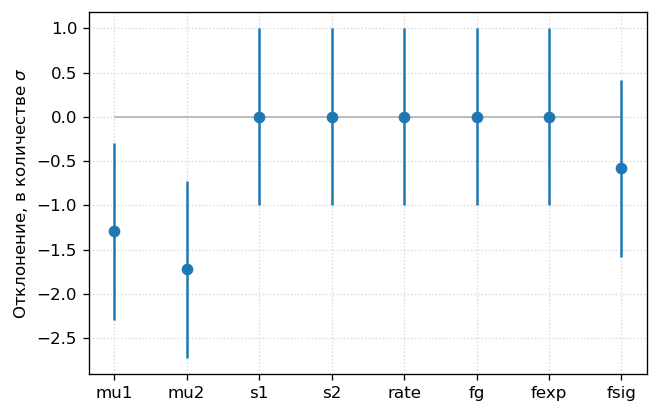

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM

## OMEGA12

In [96]:
df_signal = pd.read_csv('../data/12_omega/results/signal.csv', index_col=0)
df_tr = pd.read_csv('../data/12_omega/results/triggers.csv', index_col=0)
df_lum = pd.read_csv('../data/12_omega/results/lum.csv', index_col=['energy'])

In [117]:
df = pd.concat([df_signal, df_tr, df_lum], axis=1).dropna()
df['emeas'] *= 2

In [118]:
df['corr'] = pd.Series({
    507.: 0.71*0.987,
    508.: 0.7*0.983,
    509.: 0.72*1.028,
    510.: 0.83*0.994,
    512.: 1.08*0.996,
    525.: 1.79,
})

In [122]:
df

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,effC,effT_err,effC_err,eff_trig,eff_trig_err,lum,lum_err,corr,cs,cs_err
507.0,2139.652883,1.735464e+01,-0.221485,2.655027,2.900028,0.082329,0.076101,19.803762,38.170744,18.192832,...,0.244869,0.007277,0.009285,0.977667,0.005502,70.5469,0.398893,0.70077,213.287492,5.179893
508.0,5562.765273,6.232596e+00,-0.206608,2.721032,2.885417,0.080199,0.071471,17.142645,58.740330,18.976131,...,0.231201,0.005366,0.005675,0.969341,0.004131,60.8262,0.369406,0.68810,644.921120,11.124008
509.0,10821.905227,5.009531e+01,-0.178266,2.633571,2.726754,0.079726,0.076751,0.141352,76.973779,41.506804,...,0.220983,0.004185,0.004000,0.964363,0.003265,52.9112,0.347086,0.74016,1317.707782,19.330169
510.0,8173.782225,4.621083e+01,0.009122,2.771344,3.085351,0.084184,0.076454,19.979887,96.630348,47.192487,...,0.214110,0.004603,0.004544,0.968443,0.003622,58.9441,0.367584,0.82502,808.376911,12.522251
512.0,2480.864823,1.101360e+02,-0.511940,2.434352,5.067231,0.079610,0.096723,19.999999,62.830554,51.473510,...,0.222870,0.007883,0.008206,0.970010,0.006135,57.4664,0.363189,1.07568,181.537500,4.129569
525.0,713.999993,1.109287e-08,0.155742,2.780076,2.144564,0.096825,0.192229,2.801567,18.894347,0.728413,...,0.208745,0.017604,0.015252,0.959423,0.013951,197.4100,0.690676,1.79000,16.902194,0.675496


In [120]:
df['cs'] = df['n_sig_exp']*20000/(df['n_sig_mc']*df['lum']*df['eff_trig']*df['corr'])
df['cs_err'] = df['cs']*np.sqrt( (1/df['n_sig_exp']) +
                               (df['n_sig_mc_err']/df['n_sig_mc'])**2)

In [137]:
df[['emeas', 'cs', 'cs_err', 'lum']]

,emeas,cs,cs_err,lum
507.0,1015.087097,213.287492,5.179893,70.5469
508.0,1017.171997,644.921120,11.124008,60.8262
509.0,1019.088562,1317.707782,19.330169,52.9112
510.0,1021.374329,808.376911,12.522251,58.9441
512.0,1025.427490,181.537500,4.129569,57.4664
525.0,1050.750122,16.902194,0.675496,197.4100


In [134]:
df_koz = pd.read_csv('../data/other/kskl_kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born', 'cs_err': 'cs_born_err'}, axis=1)
# df_koz['emeas'] /= 2

In [135]:
df_koz[['emeas', 'cs_born', 'cs_born_err']]

,emeas,cs_born,cs_born_err
0,1004.066,6.87,0.42
1,1010.466,42.16,0.47
2,1012.955,96.74,1.00
3,1015.068,219.53,5.02
4,1016.105,366.33,3.33
5,1017.155,628.15,2.95
6,1017.156,624.76,9.89
7,1018.046,996.62,4.28
8,1019.118,1413.65,6.02
9,1019.214,1433.05,15.03


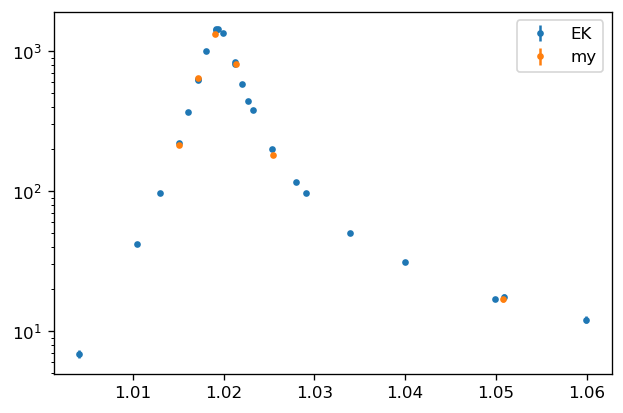

In [136]:
plt.errorbar(df_koz.emeas*1e-3, df_koz.cs_born, yerr=df_koz.cs_born_err, fmt='.', label='EK');
plt.errorbar(df.emeas*1e-3, df.cs, yerr=df.cs_err, fmt='.', label='my')
plt.legend()
plt.yscale('log')

## [Pull distribution](http://physics.rockefeller.edu/luc/technical_reports/cdf5776_pulls.pdf)

In [27]:
dfE, dfM = get_x1(df_exp, df_mc, 525)
dfE, dfM = dfE.query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').copy(), dfM.query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').copy()
dataE, dataM = dfE.x1.values, dfM.x1.values

In [39]:
from progressbar import progressbar

In [74]:
SAMPLE_SIZE, N_SAMPLES = 400, 400
for i in progressbar(range(N_SAMPLES)):
    dataM_sample = np.random.choice(dataM, SAMPLE_SIZE)
    m_mc_sample = pyfit.fitter(dataM_sample, fit_range, params.copy(), mc=True)
    m_mc_sample.simplex().migrad(iterate=20)
    if i==0:
        vals = {p : np.empty(N_SAMPLES) for p in m_mc_sample.parameters}
        errs = {p : np.empty(N_SAMPLES) for p in m_mc_sample.parameters}
    for par in m_mc_sample.parameters:
        vals[par][i] = m_mc_sample.values[par]
        errs[par][i] = m_mc_sample.errors[par]

100% (400 of 400) |######################| Elapsed Time: 0:01:27 Time:  0:01:27


In [155]:
parameter = 'n_sig'
pull = (vals[parameter]-vals[parameter].mean())/errs[parameter]

In [156]:
from iminuit import cost, Minuit
gauss = lambda x, n0, mean, sigma: n0*np.exp(-(x - mean)**2/(2*(sigma**2)))/np.sqrt(2*np.pi*(sigma**2))
costF = cost.ExtendedUnbinnedNLL(pull, lambda x, n0, mean, sigma : (n0, gauss(x, n0, mean, sigma)))
m_pull = Minuit(costF, 400, 0, 1).simplex().migrad()

In [157]:
m_pull

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -7710                      │              Nfcn = 200              │
│ EDM = 1.16e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n0    │    400    │    20     │            │            │         │         │       │
│ 1 │ mean  │     0     │  0.12e-3  │            │            │         │         │       │
│ 2 │ sigma │  2.32e-3  │  0.08e-3  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       n0     mean    sigma │
├───────┼────────────────────────────┤
│    n0 │      400 6.31e-12 2.04e-12 │
│  mean │ 6.31e-12 1.35e-08 1.51e-11 │
│ sigma │ 2.04e-12 1.51e-11 6.74e-09 │
└───────┴────────────────────────────┘

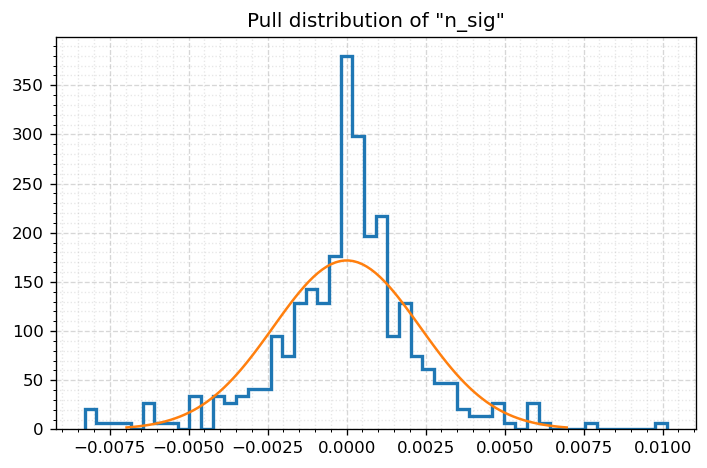

In [158]:
plt.hist(pull, bins=50, histtype='step', lw=2, density=True); #Pull distribution
x_pdf = np.linspace(-3*m_pull.values['sigma'], 3*m_pull.values['sigma'], 100)
plt.plot(x_pdf, gauss(x_pdf, 1, m_pull.values['mean'],  m_pull.values['sigma']))
pys.my_style(f'Pull distribution of "{parameter}"')

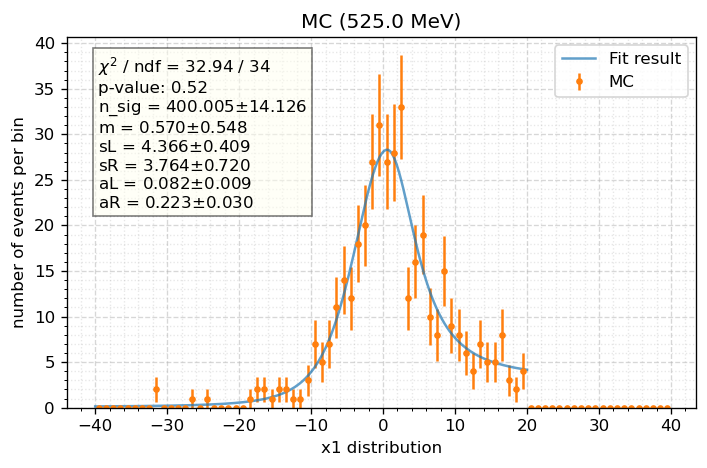

In [81]:
pys.plot_fit(dataM_sample, pyfit.sig_pdf, m_mc_sample, 80, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)